##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# MoveNet: Ultra fast and accurate pose detection model.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/movenet"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/movenet.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=movenet"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

**[MoveNet](https://t.co/QpfnVL0YYI?amp=1)** is an ultra fast and accurate model that detects 17 keypoints of a body. The model is offered on [TF Hub](https://tfhub.dev/s?q=movenet) with two variants, known as Lightning and Thunder. Lightning is intended for latency-critical applications, while Thunder is intended for applications that require high accuracy. Both models run faster than real time (30+ FPS) on most modern desktops, laptops, and phones, which proves crucial for live fitness, health, and wellness applications.


<img src="https://github.com/tensorflow/tfjs-models/raw/master/pose-detection/assets/combined_squat_dance.gif" alt="drawing"/>

*Images downloaded from Pexels (https://www.pexels.com/)

This Colab walks you through the details of how to load MoveNet, and run inference on the input image and video below.

Note: check out the [live demo](https://storage.googleapis.com/tfjs-models/demos/pose-detection/index.html?model=movenet) for how the model works!

# Human Pose Estimation with MoveNet

## Visualization libraries & Imports

In [2]:
#!pip install -q imageio
#!pip install -q opencv-python
#!pip install -q git+https://github.com/tensorflow/docs

In [3]:
#!pip install tensorflow_hub
#!pip install tensorflow_docs

In [4]:
#!pip install opencv-python

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd
import platform

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [2]:
#@title Helper functions for visualization

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'fuchsia',
    (7, 9): 'fuchsia',
    (6, 8): 'darkcyan',
    (8, 10): 'darkcyan',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

## Load Model from TF hub

In [3]:
model_name = "movenet_thunder" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

2024-07-03 16:49:48.520916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Single Image Example

This session demonstrates the minumum working example of running the model on a **single image** to predict the 17 human keypoints.

In [11]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS🐑🏀/Human Action Recognition'
else:
    root_directory = a 

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/human_pose
data directory is /Users/lorenzobarbiero/Desktop/Università/VCS🐑🏀/Human Action Recognition


### Load Input Image

In [8]:
#!curl -o input_image.jpeg https://images.pexels.com/photos/4384679/pexels-photo-4384679.jpeg --silent

In [13]:
# Load the input image.

image_path = data_directory + '/train/Image_87.jpg'
#image_path = 'photo_5863763457768276834_y.jpg'
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

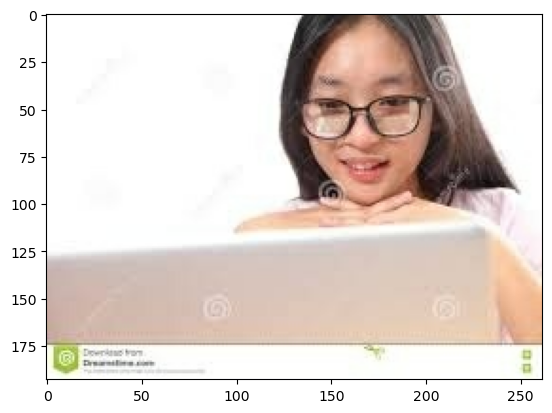

In [14]:
plt.imshow(image)

### Run Inference

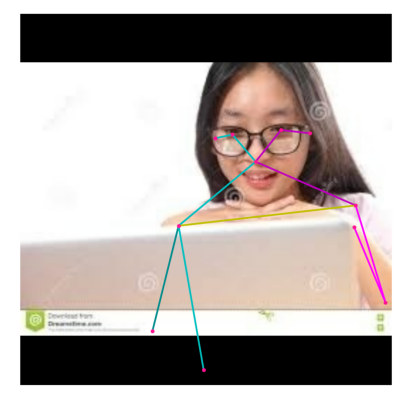

In [15]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoints_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)

plt.figure(figsize=(5, 5))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [16]:
keypoints_with_scores

array([[[[0.39760366, 0.6337671 , 0.66706026],
         [0.3122344 , 0.7021836 , 0.7853375 ],
         [0.32455456, 0.57122445, 0.73979753],
         [0.32102785, 0.78019136, 0.5093826 ],
         [0.33432594, 0.5252049 , 0.53428614],
         [0.5154087 , 0.90312564, 0.52794164],
         [0.5701569 , 0.42626485, 0.68236715],
         [0.77709544, 0.98363686, 0.35330486],
         [0.8544702 , 0.35563293, 0.15706033],
         [0.5742659 , 0.8992891 , 0.41988182],
         [0.7224712 , 0.46364602, 0.0874453 ],
         [0.8778617 , 0.8007113 , 0.05116187],
         [0.95875365, 0.49381807, 0.18169929],
         [0.6634375 , 0.9432913 , 0.02521384],
         [0.5832754 , 0.40469787, 0.08727323],
         [0.49303803, 0.5764176 , 0.0858596 ],
         [0.64170593, 0.6625846 , 0.00738892]]]], dtype=float32)

(0.0, 1.0)

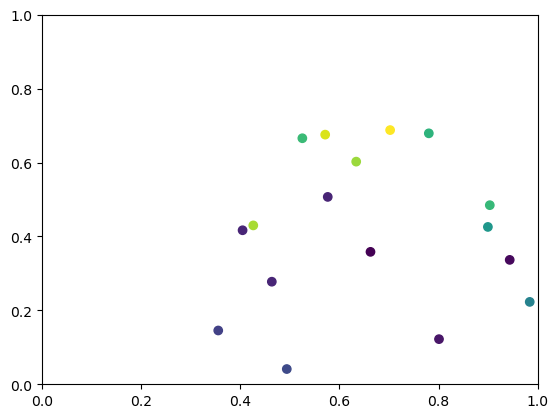

In [17]:
x = keypoints_with_scores.reshape(17,3)[:,1]
y = 1 - keypoints_with_scores.reshape(17,3)[:,0]
color = keypoints_with_scores.reshape(17,3)[:,2]
plt.scatter(x, y, c=color)
plt.xlim(0,1)
plt.ylim(0,1)

In [21]:
df = pd.read_csv(data_directory+'/Training_set.csv')

In [22]:
# assign number to the label column of the df
df['label'] = df['label'].astype('category')
df['category'] = df['label'].cat.codes
df

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
...,...,...,...
12595,Image_12596.jpg,sitting,11
12596,Image_12597.jpg,clapping,1
12597,Image_12598.jpg,sitting,11
12598,Image_12599.jpg,dancing,3


In [23]:
# define a function that takes as input the image path and returns the image with the keypoints and the category
def image_keypoints_category(image_path, df):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    return [(keypoints_with_scores).flatten(),
             df[df['filename'] == image_path.split('/')[-1]]['category'].values[0]]


In [42]:
# define a function that takes as input the image path and returns the image with the keypoints and the category
def image_keypoints(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoints_with_scores = movenet(input_image)

    return keypoints_with_scores.reshape(17,3)

In [44]:
image_path = data_directory + '/train/Image_87.jpg'
data = image_keypoints(image_path)
data

array([[0.39760366, 0.6337671 , 0.66706026],
       [0.3122344 , 0.7021836 , 0.7853375 ],
       [0.32455456, 0.57122445, 0.73979753],
       [0.32102785, 0.78019136, 0.5093826 ],
       [0.33432594, 0.5252049 , 0.53428614],
       [0.5154087 , 0.90312564, 0.52794164],
       [0.5701569 , 0.42626485, 0.68236715],
       [0.77709544, 0.98363686, 0.35330486],
       [0.8544702 , 0.35563293, 0.15706033],
       [0.5742659 , 0.8992891 , 0.41988182],
       [0.7224712 , 0.46364602, 0.0874453 ],
       [0.8778617 , 0.8007113 , 0.05116187],
       [0.95875365, 0.49381807, 0.18169929],
       [0.6634375 , 0.9432913 , 0.02521384],
       [0.5832754 , 0.40469787, 0.08727323],
       [0.49303803, 0.5764176 , 0.0858596 ],
       [0.64170593, 0.6625846 , 0.00738892]], dtype=float32)

In [45]:
def norm_keypoints(data):
    # Amplitude estimate for each axes
    norm_factor_x = np.percentile(data[:, 0], 95) - np.percentile(data[:, 0], 5)
    norm_factor_y = np.percentile(data[:, 1], 95) - np.percentile(data[:, 1], 5)

    data[:, 0] = (data[:, 0] - np.percentile(data[:, 0], 5)) / norm_factor_x
    data[:, 1] = (data[:, 1] - np.percentile(data[:, 1], 5)) / norm_factor_y

    return data

In [46]:
data = norm_keypoints(data)

data

array([[ 0.13628823,  0.42927718,  0.66706026],
       [-0.01223922,  0.55222327,  0.7853375 ],
       [ 0.00919568,  0.31688648,  0.73979753],
       [ 0.00305982,  0.6924051 ,  0.5093826 ],
       [ 0.02619616,  0.23418823,  0.53428614],
       [ 0.3412482 ,  0.91332096,  0.52794164],
       [ 0.43650037,  0.05639056,  0.68236715],
       [ 0.796537  ,  1.0580015 ,  0.35330486],
       [ 0.93115544, -0.07053671,  0.15706033],
       [ 0.44364935,  0.90642655,  0.41988182],
       [ 0.70150036,  0.12356544,  0.0874453 ],
       [ 0.9718525 ,  0.7292799 ,  0.05116187],
       [ 1.1125902 ,  0.17778534,  0.18169929],
       [ 0.5987922 ,  0.9854996 ,  0.02521384],
       [ 0.45932424,  0.01763416,  0.08727323],
       [ 0.3023272 ,  0.32621872,  0.0858596 ],
       [ 0.5609831 ,  0.4810629 ,  0.00738892]], dtype=float32)

In [51]:
def get_dataset(df, data_directory):
    
    keypoints_dataset = np.zeros((len(df),17,3))
    
    for i, file in enumerate(df['filename']):
        
        keypoints_dataset[i,:,:] = norm_keypoints(image_keypoints(data_directory + '/train/' + file))
        
    return keypoints_dataset
        

In [52]:
df.head(10)

,filename,label,category
0,Image_1.jpg,sitting,11
1,Image_2.jpg,using_laptop,14
2,Image_3.jpg,hugging,7
3,Image_4.jpg,sleeping,12
4,Image_5.jpg,using_laptop,14
5,Image_6.jpg,sleeping,12
6,Image_7.jpg,drinking,4
7,Image_8.jpg,hugging,7
8,Image_9.jpg,clapping,1
9,Image_10.jpg,dancing,3


In [57]:
testing = get_dataset(df.head(10), data_directory)

testing_labels = df.head(10)['category']

testing.shape

(10, 17, 3)

In [58]:
testing_labels

0    11
1    14
2     7
3    12
4    14
5    12
6     4
7     7
8     1
9     3
Name: category, dtype: int8

In [60]:
tensorflow_data = tf.data.Dataset.from_tensor_slices((testing, testing_labels))

tensorflow_data

<TensorSliceDataset element_spec=(TensorSpec(shape=(17, 3), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int8, name=None))>

In [61]:
for d, l in tensorflow_data:
  print((d.numpy().shape), l.numpy().shape)

(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()
(17, 3) ()


In [25]:
image_path = data_directory + '/train/Image_87.jpg'
image_keypoints_category(image_path, df)

[array([0.39760366, 0.6337671 , 0.66706026, 0.3122344 , 0.7021836 ,
        0.7853375 , 0.32455456, 0.57122445, 0.73979753, 0.32102785,
        0.78019136, 0.5093826 , 0.33432594, 0.5252049 , 0.53428614,
        0.5154087 , 0.90312564, 0.52794164, 0.5701569 , 0.42626485,
        0.68236715, 0.77709544, 0.98363686, 0.35330486, 0.8544702 ,
        0.35563293, 0.15706033, 0.5742659 , 0.8992891 , 0.41988182,
        0.7224712 , 0.46364602, 0.0874453 , 0.8778617 , 0.8007113 ,
        0.05116187, 0.95875365, 0.49381807, 0.18169929, 0.6634375 ,
        0.9432913 , 0.02521384, 0.5832754 , 0.40469787, 0.08727323,
        0.49303803, 0.5764176 , 0.0858596 , 0.64170593, 0.6625846 ,
        0.00738892], dtype=float32),
 14]

In [37]:
# train a model to predict the category of the image based on the keypoints
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(51,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(6)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# load the data
data = []

for i in range(10):
    image_path = data_directory+ '/train/' + df['filename'][i]
    data.append(image_keypoints_category(image_path, df))
    
data[:][1]


[array([0.44323644, 0.7618702 , 0.80649245, 0.4158148 , 0.76057094,
        0.86060333, 0.41606715, 0.7415104 , 0.883561  , 0.41297758,
        0.70586467, 0.7158857 , 0.4144127 , 0.6679407 , 0.89432067,
        0.47679898, 0.681644  , 0.7502616 , 0.4660596 , 0.58988446,
        0.78867257, 0.59241354, 0.72278637, 0.45319927, 0.6457269 ,
        0.57956123, 0.8644241 , 0.5776659 , 0.79125106, 0.40079954,
        0.5927002 , 0.7416636 , 0.57186663, 0.5554879 , 0.34247115,
        0.7150763 , 0.5724078 , 0.29682693, 0.78551453, 0.5528226 ,
        0.17745912, 0.810889  , 0.5896125 , 0.05040049, 0.8614074 ,
        0.37203145, 0.13050725, 0.75779575, 0.37455443, 0.10363597,
        0.56343716], dtype=float32),
 14]

In [ ]:
# split the data into training and testing
np.random.shuffle(data)
split = int(0.8 * len(data))
train_data = data[:split]
test_data = data[split:]

# train the model
model.fit(train_data[:,0].tolist(), train_data[:,1], epochs=10)

# evaluate the model
test_loss, test_acc = model.evaluate(test_data[:,0].tolist(), test_data[:,1], verbose=2)
print('\nTest accuracy:', test_acc)